#### This notebook takes the 3-D tSNE projection of our sample and finds a 3-D rotation of that distribution that produces a 2-D projection that maximizes the range of our 'CIV distance' metric




---

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.io import fits
import richardsplot
import pandas as pd
from mpl_toolkits import mplot3d


Bad key "text.kerning_factor" on line 4 in
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [50]:
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
prop_cycle = plt.rcParams['axes.prop_cycle']
rccols = prop_cycle.by_key()['color']

In [2]:
def figsize(hscale, 
            vscale=(np.sqrt(5.0)-1.0)/2.0,
            fig_width_pt = 336.0):
   

    """
    Get the fig_width_pt by inserting \the\textwidth into LaTeX document.

    hscale is fraction of text width you want.

    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width*vscale                   # height in inches
    fig_size = [fig_width, fig_height]

    return fig_size

In [3]:
import palettable

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.5,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 16,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis
    "axes.formatter.limits":[-5, 5],    # use sci notation if log10 of axis range is smaller than first or larger than second 
    "axes.formatter.useoffset":False,
    "font.size": 16,
    "legend.fontsize": 12,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 16,              # Font size of numbers 
    "ytick.labelsize": 16,
    'xtick.major.width':1, 
    'xtick.minor.width':1, 
    'ytick.major.width':1, 
    'ytick.minor.width':1, 
    'xtick.major.size':10,             # size of tickmarks in points
    'xtick.minor.size':5, 
    'ytick.major.size':10, 
    'ytick.minor.size':5,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'figure.autolayout': True,
    "figure.figsize": figsize(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)


csdark = palettable.colorbrewer.qualitative.Dark2_5.mpl_colors
cspurple = palettable.colorbrewer.sequential.BuPu_4.mpl_colors
csorange = palettable.colorbrewer.sequential.YlOrBr_5.mpl_colors




Need to load in data from PGv2_DR7

In [30]:
infoShen = pd.read_csv('grdr7_Shen2011_targ_uni.csv', skiprows=1, names=["name","RAx","DECx","SDSSNAME","RA","DEC","redshift","TARG_FLAG","UNI_FLAG","COLOR_FLAG","MIZ2","BALFLAGShen","FIRSTFRTYPE","FINTREST6CM","LOGFNU2500","R6CM2500A","LOGL3000","LOGL1350","Separation","AGNMask","L14"])
infoHewett = pd.read_csv('grdr7_180126.weights', sep = ' ', names=["name", "redshift", "W1", "W2", "W3", "W4", "W5", "W6"])

#Need to format weights for Scikit-Learn
weights = infoHewett[infoHewett.columns[2:]]
#print weights
X = np.array(weights)

# Array of each of the 6 weights
W1 = X[:,0]
W2 = X[:,1]
W3 = X[:,2]
W4 = X[:,3]
W5 = X[:,4]
W6 = X[:,5]

#We are going to want to restrict the redshift range, do it like this.
zem = np.array(infoHewett['redshift'])

#Read in radio data
R = np.array(infoShen['R6CM2500A']).astype(float)

# Number with z<1.75
zmask = ((zem>1.645)&(zem<=1.6519))
RLmask = (R>10)

#Mask to pick out color-selected objects (ignores radio selected and NaN [non-DR7 objects])
cMask = np.array(infoShen['COLOR_FLAG'])
infoShen

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


,name,RAx,DECx,SDSSNAME,RA,DEC,redshift,TARG_FLAG,UNI_FLAG,COLOR_FLAG,...,BALFLAGShen,FIRSTFRTYPE,FINTREST6CM,LOGFNU2500,R6CM2500A,LOGL3000,LOGL1350,Separation,AGNMask,L14
0,SDSSJ095004.94-002012.2,147.520612,-0.336744,095004.94-002012.2,147.520615,-0.336744,1.7756,1048580.0,0.0,1,...,0.0,0.0,0.0,-26.560171,-1.0,46.382682,46.565152,0.009446,0.0,23.502110
1,SDSSJ095938.28-003500.8,149.909527,-0.583571,095938.28-003500.8,149.909531,-0.583571,1.8766,1048580.0,0.0,1,...,0.0,0.0,0.0,-26.838924,-1.0,46.137213,46.353519,0.013102,0.0,0.000000
2,SDSSJ101033.44-004724.5,152.639355,-0.790145,101033.44-004724.5,152.639359,-0.790145,1.6675,4.0,0.0,1,...,1.0,0.0,0.0,-26.595548,-1.0,46.320115,46.390352,0.012673,0.0,0.000000
3,SDSSJ101100.92+002039.4,152.753859,0.344291,101100.92+002039.4,152.753860,0.344291,1.7487,1048580.0,0.0,1,...,0.0,0.0,0.0,-26.916640,-1.0,46.001362,46.245062,0.005305,0.5,24.809299
4,SDSSJ101826.85-000951.1,154.611911,-0.164201,101826.85-000951.1,154.611908,-0.164201,1.8156,4.0,0.0,1,...,0.0,0.0,0.0,-26.886154,-1.0,46.070706,46.270169,0.010948,1.0,25.126078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8648,SDSSJ154324.86+005138.7,235.853612,0.860770,154324.86+005138.7,235.853607,0.860770,2.0887,2.0,0.0,1,...,0.0,0.0,0.0,-26.773231,-1.0,46.264699,46.506456,0.017358,0.5,25.084326
8649,SDSSJ160703.27+184322.6,241.763646,18.722945,160703.27+184322.6,241.763641,18.722944,2.0450,1048578.0,1.0,1,...,0.0,0.0,0.0,-27.059151,-1.0,45.938374,46.190533,0.016052,0.0,0.000000
8650,SDSSJ153912.32+152806.2,234.801363,15.468401,153912.32+152806.2,234.801361,15.468401,1.7251,1048579.0,1.0,1,...,0.0,0.0,0.0,-27.181858,-1.0,45.722878,45.928643,0.006650,0.0,0.000000
8651,SDSSJ151827.93+075100.2,229.616412,7.850081,151827.93+075100.2,229.616409,7.850081,1.9867,33554432.0,0.0,0,...,0.0,0.0,0.0,-27.510918,-1.0,45.511671,45.686235,0.009623,1.0,25.168561


In [31]:
projTSNE3 = np.load('tSNE3_DR7.npy')
projTSNE3col = projTSNE3[cMask>0]
projTSNE3radcol = projTSNE3[(cMask>0)&(RLmask)]
projTSNE3colz = projTSNE3[(cMask>0)&(zmask)]

In [159]:
infoTrevor = pd.read_csv('../SpringFinalFigs_moreParams.csv')
infoTrevor.sort_values('col1', inplace=True) #sort target radio data based on Paul's data
CIV_VEC = infoTrevor[['RM_DIST_SCALE']].values.flatten()
CIV_VEC.shape

det = infoTrevor[["detection"]].values.flatten() + infoTrevor[["FIRST"]].values.flatten()
f = np.log10(infoTrevor[["int_flux"]].values.flatten())

In [160]:
#%matplotlib notebook

fig = plt.figure(figsize=(14,12))
ax = plt.axes(projection="3d")

ax.scatter3D(projTSNE3radcol[:,0], projTSNE3radcol[:,1], projTSNE3radcol[:,2], c='w', edgecolor="k",s=20)
p = ax.scatter3D(projTSNE3colz[:,0][CIV_VEC>0], projTSNE3colz[:,1][CIV_VEC>0], projTSNE3colz[:,2][CIV_VEC>0], c=CIV_VEC[CIV_VEC>0], cmap="bwr", edgecolor="None",s=400, marker="*")

#Take avg of N reddest/bluest points
Navg = 2

hiciv_pts = CIV_VEC[CIV_VEC>0].argsort()[-Navg:][::-1]
red_pts = np.array([projTSNE3colz[CIV_VEC>0][hiciv_pts[i]] for i in range(len(hiciv_pts))])
avgred = red_pts.mean(axis=0)

lowciv_pts = CIV_VEC[CIV_VEC>0].argsort()[:Navg][::-1]
blue_pts = np.array([projTSNE3colz[CIV_VEC>0][lowciv_pts[i]] for i in range(len(lowciv_pts))])
avgblue = blue_pts.mean(axis=0)

#Avg of reddest pts
#ax.scatter3D(avgred[0], avgred[1], avgred[2], c="orange", edgecolor="None",s=400, marker="*")

#Avg of bluest pts
#ax.scatter3D(avgblue[0], avgblue[1], avgblue[2], c="m", edgecolor="None",s=400, marker="*")


cbar = fig.colorbar(p)
cbar.ax.set_ylabel("CIV Distance")

ax.set_xlabel("Proj A")
ax.set_ylabel("Proj B")
ax.set_zlabel("Proj C")

#plt.savefig("3D_rotationPlots/tSNE3_CIV.pdf")

plt.show()

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (0,4) and requested shape (50,4)

<Figure size 1008x864 with 2 Axes>

In [35]:
#This is a nice way to track which quadrant each point is in
class tSNEpt():
    def __init__(self, pt):
        self.__x = pt[0]
        self.__y = pt[1]
        self.__z = pt[2]
        self.__quad = 0
    
    def get_quad(self):
        return self.__quad
    
    def set_quad(self):
        x = self.__x
        y = self.__y
        
        #We actually only care about the 2-D projection
        #that maximizes the distance between ends of CIV distribution
        if x >=0 and y >=0:
            self.__quad = 1
        elif x < 0 and y >= 0:
            self.__quad = 2
        elif x < 0 and y < 0:
            self.__quad = 3
        elif x >= 0 and y < 0:
            self.__quad = 4

In [36]:
def rotation(theta):
    return np.array(([np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]))

In [37]:
maxnum = 0
projTSNE3_rot = projTSNE3.copy()
projTSNE3col_rot = projTSNE3_rot[cMask>0]
projTSNE3radcol_rot = projTSNE3_rot[(cMask>0)&(RLmask)]
projTSNE3colz_rot = projTSNE3_rot[(cMask>0)&(zmask)]
opt_rotation = projTSNE3_rot


#Store all points as objects in list to iterate through
pt_objects = []
for i in range(len(projTSNE3)):
    pt_objects.append(tSNEpt(projTSNE3[i]))

#Create list of quadrants each point is in
quadrants = []
for pt in pt_objects:
    pt.set_quad()
    quadrants.append(pt.get_quad())

#Iterate through each quadrant
for i in range(1, max(quadrants)+1):
    print(quadrants.count(i))
    if quadrants.count(i) > maxnum: 
        maxnum = quadrants.count(i)
        opt_rotation = projTSNE3_rot
        

2591
1674
2627
1761


^That's the idea.  Now, want to throw it in a loop and:

* Rotate all points in the xy plane some angle $\theta_{xy}$
    * For each xy rotation, rotate the points in the yz plane in increments $\phi_{yz}$ all the way through to $2\pi$


* Compute xy distance between 'most and least' CIV distance.  If it's greater than the current max distance, update that value and change 'opt_rotation' to the current rotation


\begin{equation*}
R = 
\begin{pmatrix}
\cos\theta & -\sin\theta  \\
\sin\theta & \cos\theta
\end{pmatrix}
\end{equation*}

In [38]:
for theta in np.arange(0, 2*np.pi, np.pi/6): print(theta) 

0.0
0.5235987755982988
1.0471975511965976
1.5707963267948966
2.0943951023931953
2.617993877991494
3.141592653589793
3.665191429188092
4.1887902047863905
4.71238898038469
5.235987755982988
5.759586531581287


In [39]:
np.array([projTSNE3[:,0], projTSNE3[:,1]]).T

array([[ 3.3992834, -0.6594   ],
       [ 7.2845545, -5.2929096],
       [14.227501 ,  8.701422 ],
       ...,
       [12.092185 ,  7.266762 ],
       [11.2877655, -7.0342875],
       [-1.0075307,  7.4919   ]], dtype=float32)

In [40]:
CIV_VEC

array([2.9554997 , 2.54798822, 3.29342446, 3.48625645, 2.5899685 ,
       1.73339943, 5.63786704, 3.4066913 , 3.02983482, 2.70444515,
       2.63562523, 2.78883837, 1.7104863 , 3.66255872, 2.95846692,
       2.63567543, 4.94347956, 5.67397212, 2.33106725, 3.56182944,
       2.6597353 , 3.01438036, 3.44224633, 3.53079314, 6.64521151,
       2.80351796, 5.38802337, 2.11997069, 2.00301995, 2.05685756,
       4.3747732 , 2.20758141, 3.55528746, 2.60345984, 3.16582444,
       3.56814236, 2.70883525, 2.89985178, 2.02668204, 2.89642907,
       2.48333446, 3.2579722 , 2.91160868, 3.21718353, 3.12041777,
       3.49263399, 2.2115606 , 3.28971694, 2.80126209, 2.16014924])

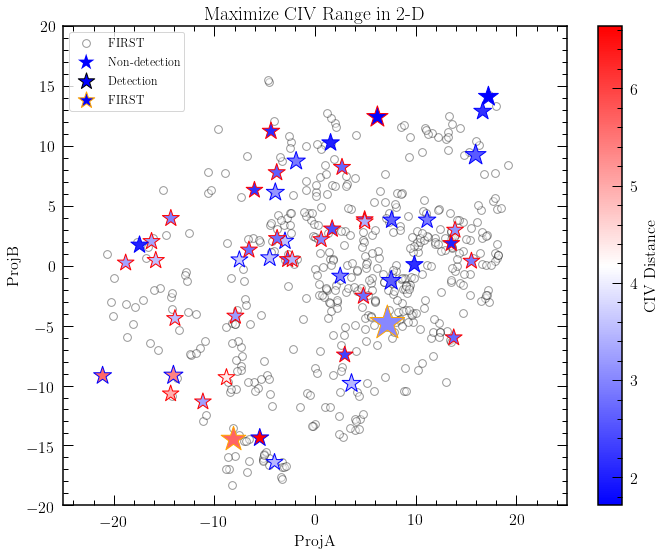

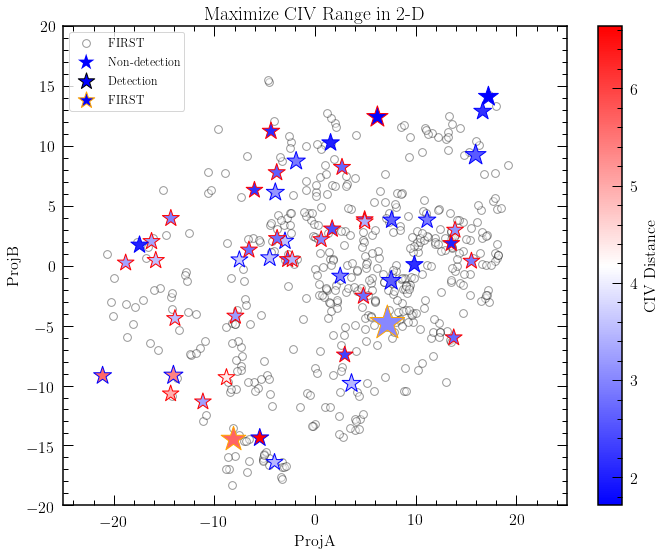

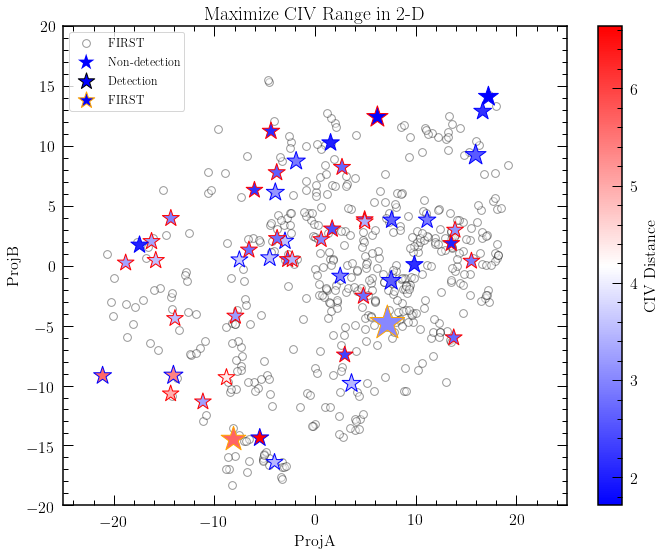

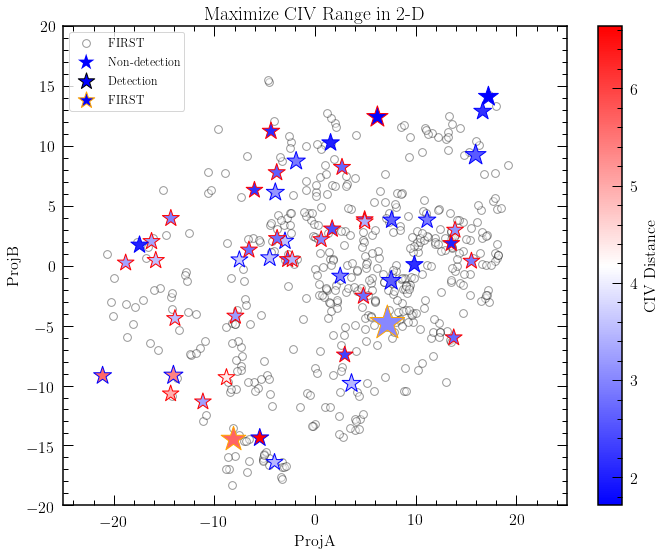

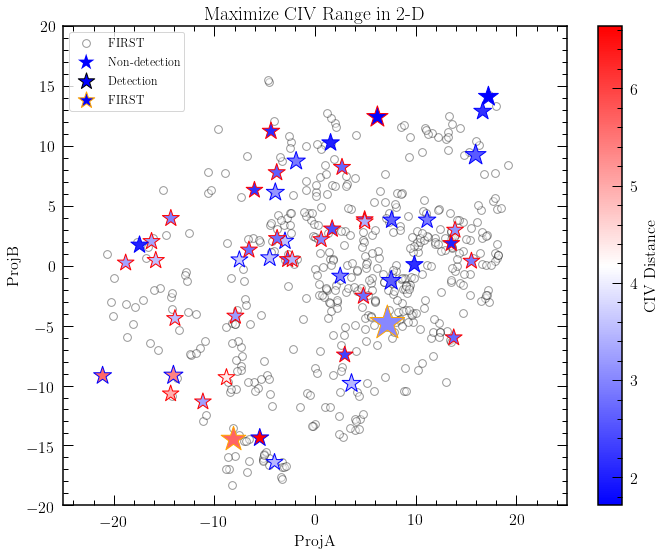

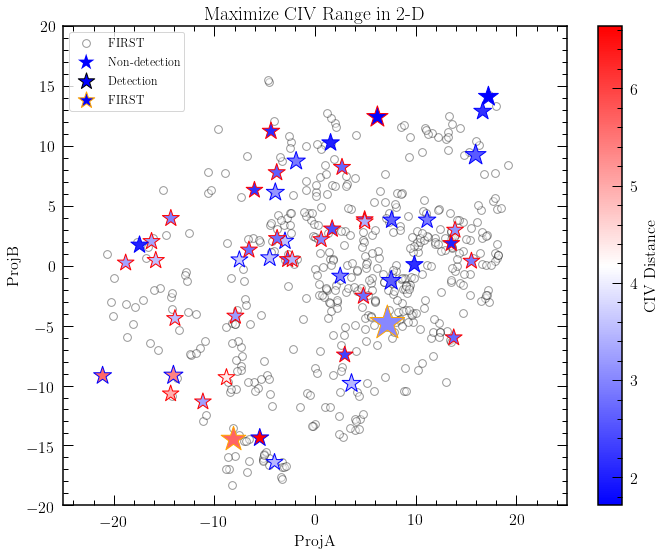

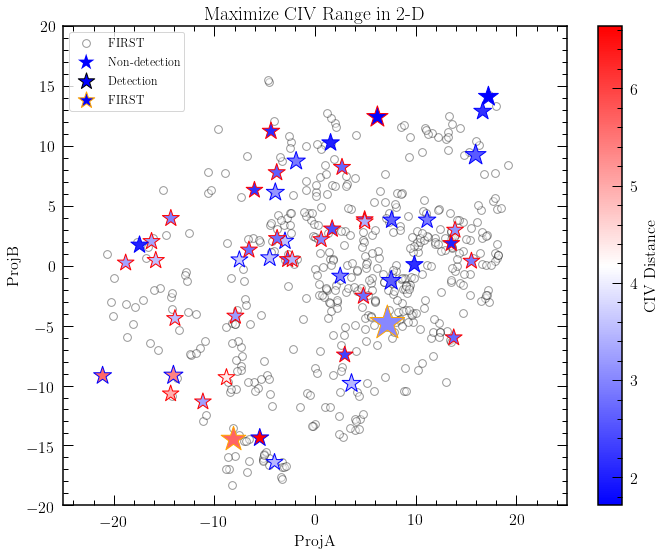

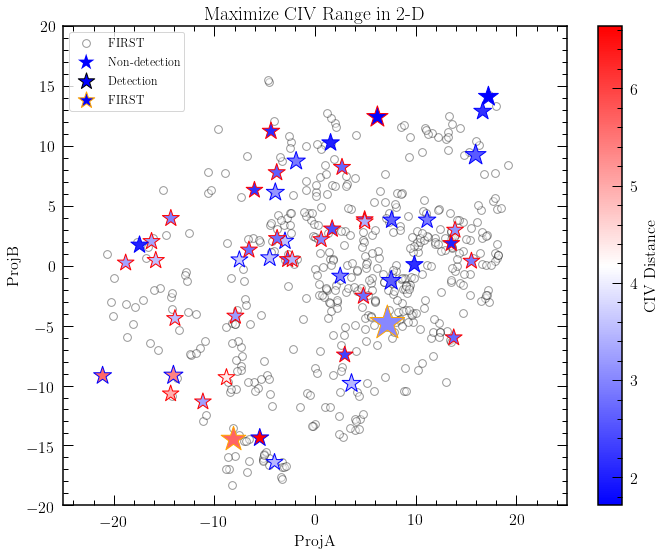

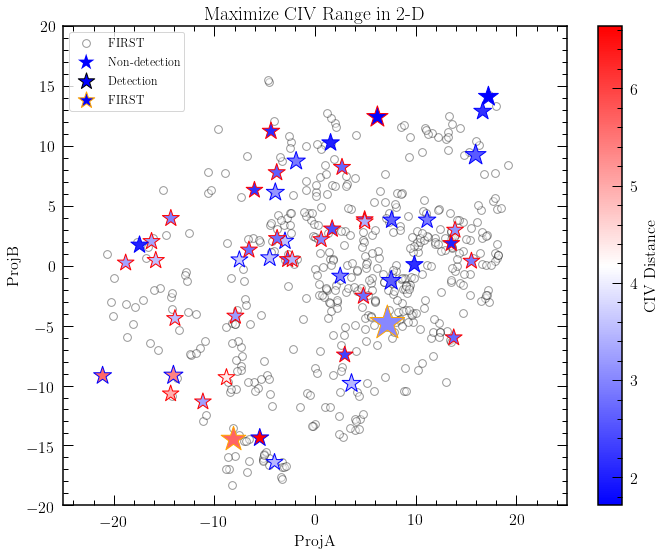

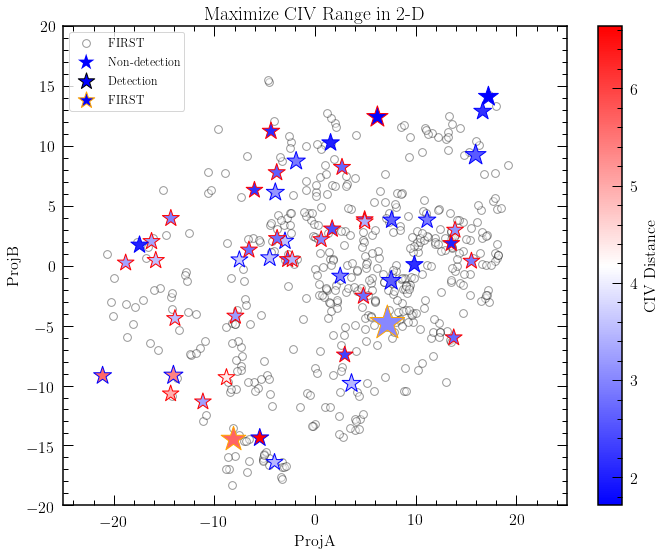

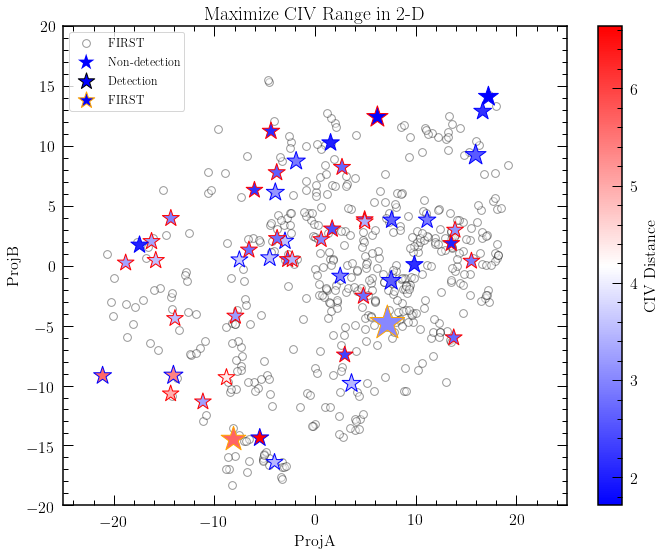

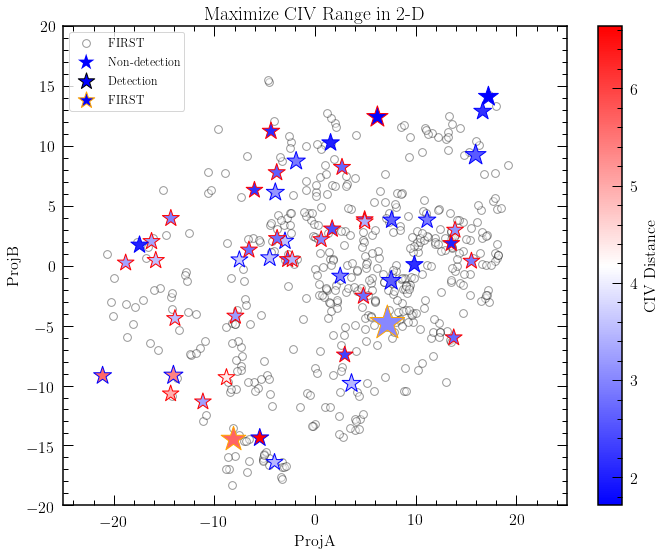

In [62]:
#%matplotlib notebook

edgecols = ["red", "blue", "orange"]
edgecolors = []
for i in range(len(CIV_VEC)):
    edgecolors.append(edgecols[int(det[i])])

#fig = plt.figure(figsize=(10,10))
#ax = plt.axes(projection="3d")

#Increase for smaller rotation increments
N = 1

#Take Navg reddest/bluest points to define red/blue area of distribution - only for 
#comparing distributions, doesn't actually change points at all
#Navg = 9

for Navg in range(1,13):
    #Track how far apart red/blue pts are in best distribution 
    maxdist = 0

    #Want to rotate a copy of the original tSNE3 projection
    projTSNE3_rot = projTSNE3.copy()
    opt_rotation = projTSNE3_rot

    for theta in np.arange(0, 2*np.pi, np.pi/N):
        #Go Back to start for each rotation
        projTSNE3_rot = projTSNE3.copy()
        xy = np.array([projTSNE3[:,0], projTSNE3[:,1]]).T

        projTSNE3_rot[:,0:2] = np.matmul(xy, rotation(theta))

        for phi in np.arange(0, 2*np.pi, np.pi/N):
            #Go back to theta for each phi rotation
            projTSNE3_rot2 = projTSNE3_rot.copy()
            yz = np.array([projTSNE3_rot[:,1], projTSNE3_rot[:,2]]).T
            projTSNE3_rot2[:,1:3] = np.matmul(yz, rotation(phi))

            projTSNE3radcol_rot2 = projTSNE3_rot2[(cMask>0)&(RLmask)]
            projTSNE3colz_rot2 = projTSNE3_rot2[(cMask>0)&(zmask)]


            #Now do stuff to check if this rotation is better
            #Get indices of highest CIV distance points
            hiciv_pts = CIV_VEC[CIV_VEC>0].argsort()[-Navg:][::-1]
            red_pts = np.array([projTSNE3colz_rot2[CIV_VEC>0][hiciv_pts[i]] for i in range(len(hiciv_pts))])
            avgred = red_pts.mean(axis=0)
            #Get indices of lowest CIV distance points, excluding missing measurements
            lowciv_pts = CIV_VEC[CIV_VEC>0].argsort()[:Navg][::-1]
            blue_pts = np.array([projTSNE3colz_rot2[CIV_VEC>0][lowciv_pts[i]] for i in range(len(lowciv_pts))])
            avgblue = blue_pts.mean(axis=0)

            #Avg of reddest pts
            #ax.scatter3D(avgred[0], avgred[1], avgred[2], c="orange", edgecolor="k",s=400, marker="*")

            #Avg of bluest pts
            #ax.scatter3D(avgblue[0], avgblue[1], avgblue[2], c="m", edgecolor="k",s=400, marker="*")



            civ_range = np.sqrt((avgred[0] - avgblue[0])**2 + (avgred[1] - avgblue[1])**2)
            if civ_range > maxdist:
                maxdist = civ_range
                opt_rotation = projTSNE3_rot2

    opt_rotation_col = opt_rotation[(cMask>0)]
    opt_rotation_colz = opt_rotation[(cMask>0)&(zmask)]
    opt_rotation_radcol = opt_rotation[(cMask>0)&(RLmask)]


    plt.figure(figsize=(10,8))

    #plt.scatter(opt_rotation_col[:,0], opt_rotation_col[:,1], c=W1[cMask>0], cmap="PRGn", 
    #            edgecolor="None", s=20, alpha=0.4)

    plt.scatter(opt_rotation_radcol[:,0], opt_rotation_radcol[:,1], 
                c='w', edgecolor="k", s=60, alpha=0.4, label="FIRST")

    plt.scatter(opt_rotation_colz[:,0], opt_rotation_colz[:,1], 
                c=CIV_VEC, cmap="bwr", edgecolor=edgecolors, s=(280+10*pf**3), marker="*")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel("CIV Distance")

    #For legend
    plt.scatter(50,50, 
                c="blue", edgecolor="None", s=300, marker="*", label="Non-detection")
    plt.scatter(50,50, 
                c="blue", edgecolor="black", s=300, marker="*", label="Detection")
    plt.scatter(50,50, 
                c="blue", edgecolor="orange", s=300, marker="*", label="FIRST")



    plt.xlim(-25,25)
    plt.ylim(-20,20)
    plt.xlabel("ProjA")
    plt.ylabel("ProjB")
    plt.title("Maximize CIV Range in 2-D")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.savefig("3D_rotationPlots/maxCIVrange_tSNE3_avg{}.pdf".format(Navg))
    plt.show()

^Covers pretty much every rotation

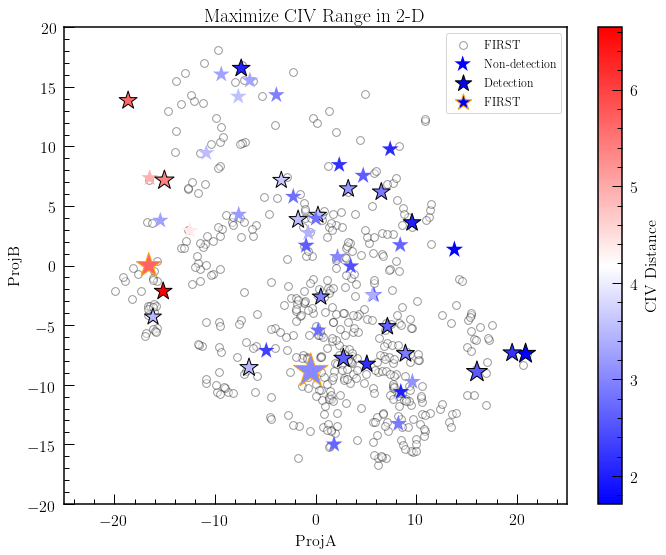

In [36]:
opt_rotation_col = opt_rotation[(cMask>0)]
opt_rotation_colz = opt_rotation[(cMask>0)&(zmask)]
opt_rotation_radcol = opt_rotation[(cMask>0)&(RLmask)]


plt.figure(figsize=(10,8))

#plt.scatter(opt_rotation_col[:,0], opt_rotation_col[:,1], c=W1[cMask>0], cmap="PRGn", 
#            edgecolor="None", s=20, alpha=0.4)

plt.scatter(opt_rotation_radcol[:,0], opt_rotation_radcol[:,1], 
            c='w', edgecolor="k", s=60, alpha=0.4, label="FIRST")


edgecols = ["None", "black", "orange"]
edgecolors = []
for i in range(len(CIV_VEC)):
    edgecolors.append(edgecols[int(det[i])])
plt.scatter(opt_rotation_colz[:,0], opt_rotation_colz[:,1], 
            c=CIV_VEC, cmap="bwr", edgecolor=edgecolors, s=(280+10*pf**3), marker="*")

cbar = plt.colorbar()
cbar.ax.set_ylabel("CIV Distance")

#For legend
plt.scatter(50,50, 
            c="blue", edgecolor="None", s=300, marker="*", label="Non-detection")
plt.scatter(50,50, 
            c="blue", edgecolor="black", s=300, marker="*", label="Detection")
plt.scatter(50,50, 
            c="blue", edgecolor="orange", s=300, marker="*", label="FIRST")



plt.xlim(-25,25)
plt.ylim(-20,20)
plt.xlabel("ProjA")
plt.ylabel("ProjB")
plt.title("Maximize CIV Range in 2-D")
plt.legend(loc="best")

plt.tight_layout()
#plt.savefig("3D_rotationPlots/maxCIVrange_tSNE3_avg{}.pdf".format(Navg))

This is the 2-D projection of our 3-D tSNE analysis which maximizes the range of the CIV distance metric

Green to purple colormap represents W1 from 6-component ICA analysis

---

Now maximize RLF or FIRST sources in a quadrant

In [63]:
N = 10

maxfrac = 0.0
maxnum = 0
projTSNE3_rot = projTSNE3.copy()
opt_rotation = projTSNE3_rot

for theta in np.arange(0, 2*np.pi, np.pi/N):
    #Go Back to start for each rotation
    projTSNE3_rot = projTSNE3.copy()
    xy = np.array([projTSNE3[:,0], projTSNE3[:,1]]).T
    projTSNE3_rot[:,0:2] = np.matmul(xy, rotation(theta))
    
    for phi in np.arange(0, 2*np.pi, np.pi/N):
        #Go back to theta for each phi rotation
        projTSNE3_rot2 = projTSNE3_rot.copy()
        yz = np.array([projTSNE3_rot[:,1], projTSNE3_rot[:,2]]).T
        projTSNE3_rot2[:,1:3] = np.matmul(yz, rotation(phi))
        
        projTSNE3radcol_rot2 = projTSNE3_rot2[(cMask>0)&(RLmask)]
        projTSNE3colz_rot2 = projTSNE3_rot2[(cMask>0)&(zmask)]
        
        
        #Store all Color-selected points as objects in list to iterate through
        '''pt_objects = []
        for i in range(len(projTSNE3_rot2)):
            pt_objects.append(tSNEpt(projTSNE3_rot2[i]))

        #Create list of quadrants each of the points are in
        quadrants = []
        for pt in pt_objects:
            pt.set_quad()
            quadrants.append(pt.get_quad())'''
            
        #Store all FIRST points as objects in list to iterate through
        pt_radcol_objects = []
        for i in range(len(projTSNE3radcol_rot2)):
            pt_radcol_objects.append(tSNEpt(projTSNE3radcol_rot2[i]))

        #Create list of quadrants each of the points are in
        quadrants_radcol = []
        for pt in pt_radcol_objects:
            pt.set_quad()
            quadrants_radcol.append(pt.get_quad())

        #Iterate through each quadrant
        #for i in range(1, max(quadrants)+1):
            #if quadrants_radcol.count(i)/quadrants.count(i) > maxfrac: 
                #maxfrac = quadrants_radcol.count(i)/quadrants.count(i)
                #print("Max Quadrant RLF = %.2f" % (100*maxfrac))
                #opt_rotation = projTSNE3_rot2
                
        for i in range(1, max(quadrants)+1):
            if quadrants_radcol.count(i) > maxnum: 
                maxnum = quadrants_radcol.count(i)
                print("Max FIRST sources = %d" % (maxnum))
                opt_rotation = projTSNE3_rot2

Max FIRST sources = 168
Max FIRST sources = 226
Max FIRST sources = 251
Max FIRST sources = 263
Max FIRST sources = 275


 for i in range(1, max(quadrants)+1):
            if quadrants_radcol.count(i) > maxnum: 
                maxnum = quadrants_radcol.count(i)
                print("Max FIRST sources = %d" % (maxnum))
                opt_rotation = projTSNE3_rot2

---

Want to make a plot of the FIRST version for the paper.  All that's left now is changing the size scaling.  Can sort of replicate the logistic curve used to set the size scaling in the CIV plots

(108.33333333333337, 3776.757987795416)

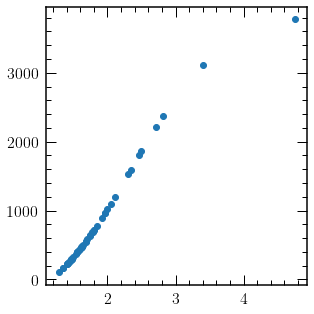

In [174]:
#Slight break in this notebook's logic - create size scaling based on radio
A = -650. #lower asymptote
K = 3900. #upper asymptote
B = 1.5 #growth rate
nu = 1. #affects where the max growth occurs
Q = 5. #related to intitial condition

logistic_radio = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(f))))**(1/nu)) for i in f])

plt.scatter(f, logistic_radio)
min(logistic_radio), max(logistic_radio)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


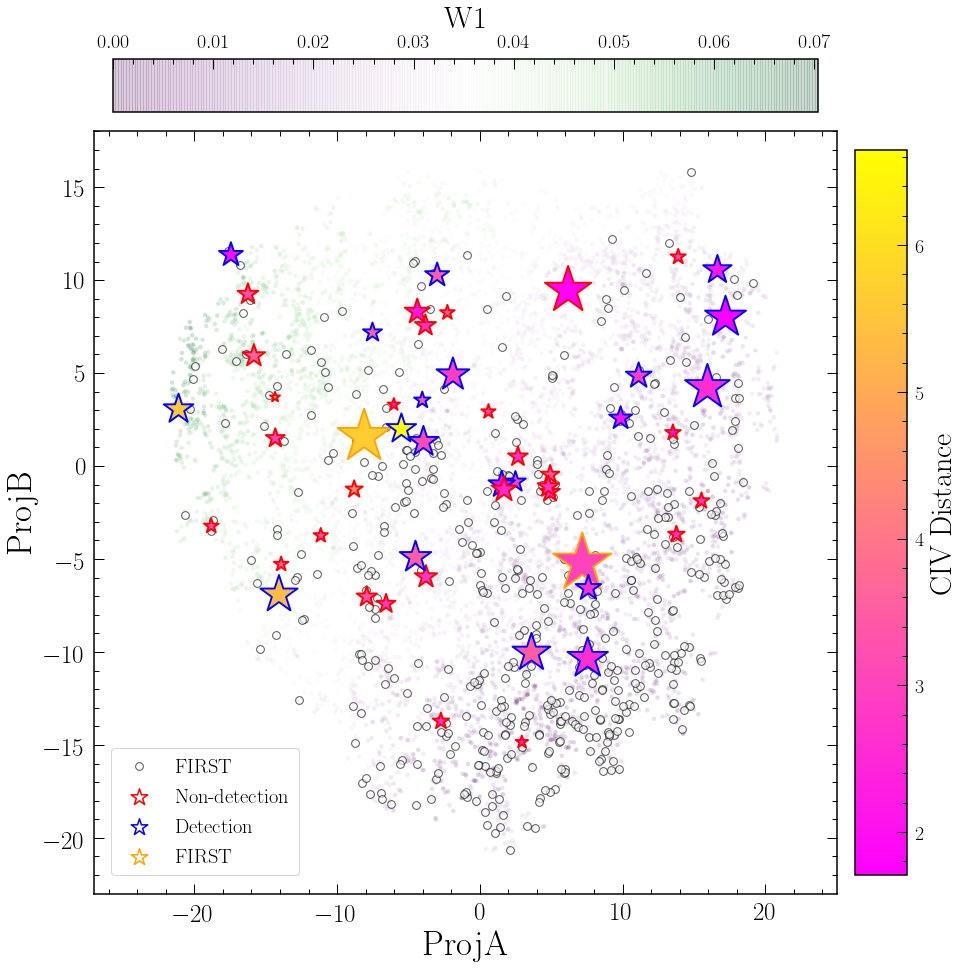

Quad 1 RLF = 2.68 percent
Quad 2 RLF = 2.27 percent
Quad 3 RLF = 5.67 percent
Quad 4 RLF = 12.35 percent


In [186]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

opt_rotation_col = opt_rotation[(cMask>0)]
opt_rotation_colz = opt_rotation[(cMask>0)&(zmask)]
opt_rotation_radcol = opt_rotation[(cMask>0)&(RLmask)]

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)

map1 = ax1.scatter(opt_rotation_col[:,0], opt_rotation_col[:,1], c=W1[cMask>0], cmap="PRGn", 
            edgecolor="None", s=20, alpha=0.2)

#Create inset axes for the 8403 color-selected quasars
axins1 = inset_axes(ax1,
                   width="95%",  # width = 5% of parent_bbox width
                   height="7%",  # height : 50%
                   loc='upper left',
                   bbox_to_anchor=(0.025, 0.095, 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
cbar = fig.colorbar(map1, cax=axins1, orientation="horizontal")
cbar.ax.set_xlabel("W1", fontsize=30)
cbar.ax.xaxis.tick_top()
cbar.ax.xaxis.set_label_position("top")
cbar.ax.tick_params(labelsize=20)

ax1.scatter(opt_rotation_radcol[:,0], opt_rotation_radcol[:,1], 
            c='w', edgecolor="k", s=60, alpha=0.65, label="FIRST")

map2 = ax1.scatter(opt_rotation_colz[:,0], opt_rotation_colz[:,1], 
            c=CIV_VEC, cmap="spring", edgecolor=edgecolors, s=logistic_radio, marker="*",
            linewidth=1.9)

#Create inset axes for our 50 quasars
axins2 = inset_axes(ax1,
                   width="7%",  # width = 5% of parent_bbox width
                   height="95%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.025, 0.025, 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
cbar = fig.colorbar(map2, cax=axins2, orientation="vertical")
cbar.ax.set_ylabel("CIV Distance", fontsize=30)
cbar.ax.tick_params(labelsize=20)

#For legend
ax1.scatter(50,50, 
            c="w", edgecolor="red", s=300, marker="*", label="Non-detection", linewidth=1.5)
ax1.scatter(50,50, 
            c="w", edgecolor="blue", s=300, marker="*", label="Detection", linewidth=1.5)
ax1.scatter(50,50, 
            c="w", edgecolor="orange", s=300, marker="*", label="FIRST", linewidth=1.5)



ax1.set_xlim(-27,25)
ax1.set_ylim(-23,18)
ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.set_xlabel("ProjA", fontsize=35)
ax1.set_ylabel("ProjB", fontsize=35)
#ax1.title("Maximize FIRST in 2-D")
ax1.legend(bbox_to_anchor=(0.29,0.205), prop={"size":20.5})

#plt.tight_layout()
plt.savefig("../PaperPlots/maxFIRSTquadrant_tSNE3.pdf", 
            bbox_inches="tight", pad_inches=0.65)
plt.show()

x  = opt_rotation[:,0]
y  = opt_rotation[:,1]

maskI = ((x>0)&(y>0))
maskII = ((x<=0)&(y>0))
maskIII = ((x<=0)&(y<=0))
maskIV = ((x>0)&(y<=0))

n_I = maskI.sum()
n_II = maskII.sum()
n_III = maskIII.sum()
n_IV = maskIV.sum()

xRL  = opt_rotation_radcol[:,0]
yRL  = opt_rotation_radcol[:,1]

mask1RL = ((xRL>0)&(yRL>0))
mask2RL = ((xRL<=0)&(yRL>0))
mask3RL = ((xRL<=0)&(yRL<=0))
mask4RL = ((xRL>0)&(yRL<=0))

RLFI = 100*(mask1RL.sum() / n_I)
RLFII = 100*(mask2RL.sum() / n_II)
RLFIII = 100*(mask3RL.sum() / n_III)
RLFIV = 100*(mask4RL.sum() / n_IV)

print ("Quad 1 RLF = %.2f percent" % RLFI)
print ("Quad 2 RLF = %.2f percent" % RLFII)
print ("Quad 3 RLF = %.2f percent" % RLFIII)
print ("Quad 4 RLF = %.2f percent" % RLFIV)